In [91]:
%matplotlib inline

import os
import sys
import time
import ctypes
import multiprocessing
import warnings

import dicom
import csv
import pickle
import scipy
import numpy as np
import pandas as pd
import tensorflow as tf

from copy import deepcopy
from collections import namedtuple
from scipy.misc import imread
from scipy import stats
from scipy import ndimage
from skimage import measure
from skimage import morphology
from skimage import feature
from skimage import data
from skimage.measure import label, regionprops, perimeter
from skimage.filters import roberts, sobel
from skimage.morphology import ball, disk, dilation, binary_erosion
from skimage.morphology import remove_small_objects, erosion, closing
from skimage.morphology import reconstruction, binary_closing
from skimage.morphology import binary_dilation, binary_opening
from skimage.segmentation import clear_border
from matplotlib import pyplot as plt

import util
reload(util);

In [2]:
# Utility functions

def save(**kwargs):
    with open('save.dat', 'wb') as f:
        pickle.dump(kwargs, f)


def load():
    with open('save.dat', 'rb') as f:
        return pickle.load(f)

## Read Basic Patient Data
* Use '7z x stage1.7z' to uncompress data.

In [3]:
_DATA_DIR = '../ct_data/stage1'
_LABELS_CSV = '../ct_data/stage1_labels.csv'
_SAMPLE_CSV = '../ct_data/stage1_sample_submission.csv'


def read_patient_labels(csv_fname):
    with open(csv_fname) as f:
        reader = csv.reader(f, delimiter=',')
        reader.next()  # skip header
        return dict([(r[0], float(r[1])) for r in reader if len(r) == 2])

In [4]:
patient_names = os.listdir(_DATA_DIR)
patient_labels = read_patient_labels(_LABELS_CSV)
test_patient_names = set(read_patient_labels(_SAMPLE_CSV).keys())

## Preprocess Data

In [5]:
def load_scans(patient_name):
    path = os.path.join(_DATA_DIR, patient_name)
    slices = [dicom.read_file(os.path.join(path, s)) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] -
                                 slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation -
                                 slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices


def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    outside_idx = (image == -2000)
    
    # Convert to Hounsfield units (HU)
    intercept = float(scans[0].RescaleIntercept)
    slope = float(scans[0].RescaleSlope)
    
    image = (slope * image + intercept).astype(np.int16)
    image[outside_idx] = -1000  # HU of air
    
    return image


def get_spacing(scan):
    # z, y, x
    ans = [scan.SliceThickness, scan.PixelSpacing[1], scan.PixelSpacing[0]]
    return [float(s) for s in ans]

In [46]:
p1_name = '0acbebb8d463b4b9ca88cf38431aac69'
# p1_name = '08528b8817429d12b7ce2bf444d264f9'
p1_scans = load_scans(p1_name)
p1_image = get_pixels_hu(p1_scans)
p1_image_resampled = util.resample(p1_image, get_spacing(p1_scans[0]), [1, 1, 1])

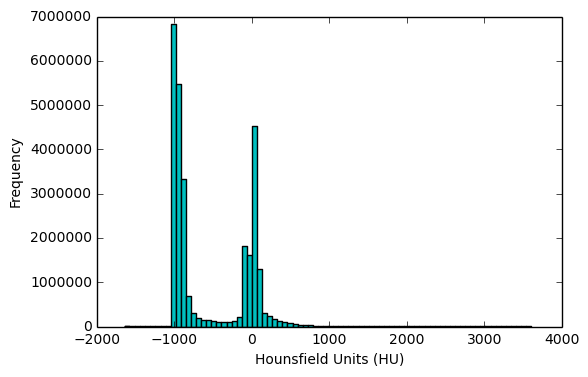

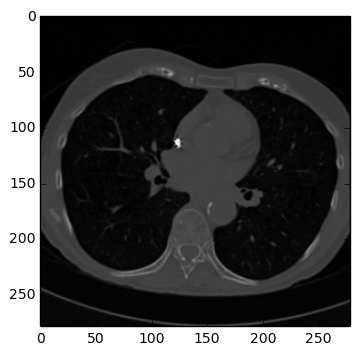

In [47]:
image = p1_image_resampled

# HU histogram
plt.figure()
plt.hist(image.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Show some slice in the middle
plt.figure()
plt.imshow(image[image.shape[0]//2], cmap=plt.cm.gray)
plt.show()

## Plot 3D

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


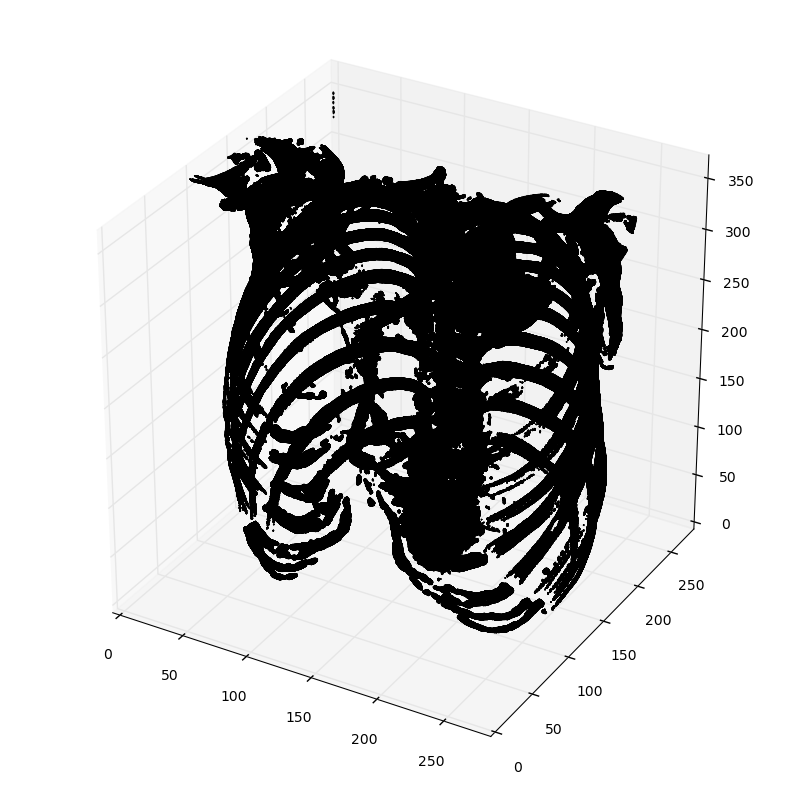

In [10]:
util.plot_3d(p1_image_resampled, 400)

## Lung Segmentation

In [ ]:
p1_lungs = util.segment_lung_mask_v2(p1_image_resampled, 1)

## Result (Preprocess + Lung Segmentation + Normalize)

In [ ]:
image = util.apply_mask(p1_image_resampled, p1_lungs)
print image.shape

z = 180

plt.figure()
plt.imshow(p1_image_resampled[z], cmap="gray")
plt.show()

plt.figure()
plt.imshow(image[z], cmap="gray")
plt.show()